# Classical ON/OFF Analysis: Exclusion regions and generating RBM maps
We've seen how to run a standard ON/OFF analysis from scratch for the most simple case. But what if we have a more complex region that requires excluding other sources, or bright stars? This tutorial will walk through how to define exclusion regions and apply them during the data preparation phase. It will also show how to use those exclusions to generate an RBM significance map.

In [1]:
# Import the standard modules
import gammalib
import ctools
import cscripts


# Import matplotlib for visualization
%matplotlib inline
import matplotlib.pyplot as plt

## Defining the input exclusion map
The primary input for defining the regions for exclusions is a skymap. If a bin in the skymap has a non-zero value then any events that fall in that bin will be excluded from analysis.

In addition to the Crab itself, we'll use the three typical stars in the field of view:
* Zeta Tauri (84.4112, 21.1426)
* O Tauri (81.9087, 21.937)
* 121 Tauri (83.863, 24.0396)

**Note:** ncluding the Crab in our exclusion map has no effect on our fit (`ctlike`) since the source region is excluded by default. However, as we'll see later, it does have an impact when we try to generate an RBM map.

In [2]:
# Define the crab position
srcname = 'Crab'
ra  = 83.633
dec = 22.0145

# Define exclusion regions (ra, dec, radius)
regions = gammalib.GSkyRegions()
regions.append(gammalib.GSkyRegionCircle(84.4112, 21.1426, 0.3))  # Zeta Tauri
regions.append(gammalib.GSkyRegionCircle(81.9087, 21.9370, 0.3))  # O Tauri
regions.append(gammalib.GSkyRegionCircle(83.8630, 24.0396, 0.3))  # 121 Tauri
excl_reg_stars = 'resources/exclmap_stars.reg'
regions.save(excl_reg_stars)

# Add the Crab
regions.append(gammalib.GSkyRegionCircle(ra, dec, 0.4))  # Crab Nebula
excl_reg_all = 'resources/exclmap_all.reg'
regions.save(excl_reg_all)

# Create a skymap
binsz = 0.02
exclmap = gammalib.GSkyMap('CAR', 'CEL', ra, dec, -binsz, binsz, 400, 400)

# Set pixels to be excluded
for indx in range(exclmap.npix()):
    dir = exclmap.inx2dir(indx)      # Get the position of the bin
    if regions.contains(dir):        # Check if the bin contains this exclusion
        exclmap[indx] += 1.0

# Save the exclusion map
exclmap_file = 'resources/exclmap.fits'
exclmap.save(exclmap_file, True)

Visualizing the the exclusion map:

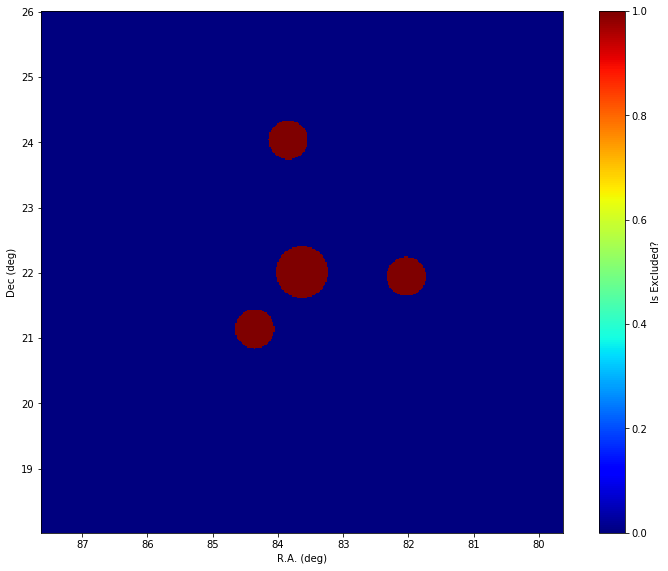

In [3]:
#module used to stretch the color palette
import matplotlib.colors as colors

# Scale the plot size
default_fs = plt.rcParamsDefault['figure.figsize']
plt.rcParams['figure.figsize'] = [2.0*v for v in default_fs]

# Define a function because we're going to be generating alot of these
def plot_skymap(skymap, ztitle, title='', norm=None):
    nx = skymap.nx()/2
    ny = skymap.ny()/2
    plt.imshow(skymap.array(),origin='lower',
               extent=[ra+binsz*nx,ra-binsz*nx,dec-binsz*ny,dec+binsz*ny],
               norm=norm, cmap=plt.get_cmap('jet')) # square root scale 
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec (deg)')
    plt.title(title)
    plt.colorbar().set_label(ztitle)

plot_skymap(exclmap, ztitle='Is Excluded?')

## Running the analysis
As we did before, the first step is to prepare the data for analysis using `csphagen`. This time, however, we will also pass in the exclusion map 

In [4]:
# Define the observation file generated in the previous tutorials
obsfile  = 'resources/obs_selected.xml'

# Setup the csphagen script
phagen = cscripts.csphagen()
phagen['inobs']         = obsfile       
phagen['inexclusion']   = exclmap_file      # The name of the exclusion map
phagen['outobs']        = 'resources/obs_onoff_unstacked_excl.xml'
phagen['outmodel']      = 'resources/onoff_unstacked_excl_model.xml'
phagen['prefix']        = 'resources/onoff_unstacked_excl'
phagen['inmodel']       = 'NONE'            # assume that the source is pointlike
phagen['ebinalg']       = 'LOG'             # Method for defining energy bins
phagen['emin']          = 0.1              # Minimum energy (TeV)
phagen['emax']          = 30.0              # Maximum energy (TeV)
phagen['enumbins']      = 20                # Number of energy bins
phagen['coordsys']      = 'CEL'             # Coord. system for analysis
phagen['ra']            = 83.633            # RA of ON region center
phagen['dec']           = 22.0145           # Dec of ON region center
phagen['rad']           = 0.1               # Radius of ON region (degrees)
phagen['bkgmethod']     = 'REFLECTED'       # Reflected region analysis
phagen['use_model_bkg'] = False             # No model for the background
phagen['maxoffset']     = 1.6               # Maximum source offset for data file to be considered
phagen['stack']         = False             # Dont stack the data

phagen.execute()

In [5]:
# Rename the source model
phagen.obs().models()['Dummy'].name(srcname)
phagen.obs().models()[srcname].tscalc(True)

# Make the Crab a log-parabola model
pref  = 3.4e-17
index = -2.4
pivot = gammalib.GEnergy(1.0, 'TeV')
curv  = -0.15
spectrum = gammalib.GModelSpectralLogParabola(pref, index, pivot, curv)

# Set the Crab spectrum
phagen.obs().models()[srcname].spectral(spectrum)

In [6]:
# Likelihood
like = ctools.ctlike(phagen.obs())
like['outmodel'] = 'resources/crab_onoff_unstacked_excl.xml'
like.execute()

# Print the results of the fit
print(like.opt())
print(like.obs().models())

=== GOptimizerLM ===
 Optimized function value ..: 15.679
 Absolute precision ........: 0.005
 Acceptable value decrease .: 2
 Optimization status .......: converged
 Number of parameters ......: 7
 Number of free parameters .: 3
 Number of iterations ......: 3
 Lambda ....................: 1e-06
=== GModels ===
 Number of models ..........: 1
 Number of parameters ......: 7
=== GModelSky ===
 Name ......................: Crab
 Instruments ...............: all
 Test Statistic ............: 901.856009189958
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "LogParabola" * "Constant"
 Number of parameters ......: 7
 Number of spatial par's ...: 2
  RA .......................: 83.633 deg (fixed,scale=1)
  DEC ......................: 22.0145 deg (fixed,scale=1)
 Number of spectral par's ..: 4
  Prefactor ................: 3.80115147576629e-17 +/- 3.75689897390162e-18 [0,infty[ ph/cm2/s/MeV (free,scale=3.4e-17,gradient)

## RBM significance map
Let's try to generate a ring-background residual-counts map from the data. Note that we're only using two observations, so it will probably look pretty terrible.

To generate the map we will use `ctskymap` again, but this time we'll set the background subtraction method to 'RING'

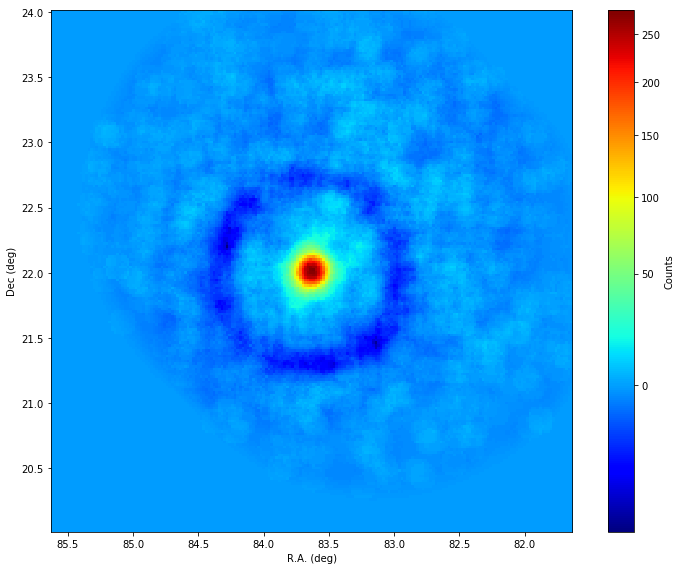

In [7]:
# Run ctskymap
skymap = ctools.ctskymap()
skymap['inobs']       = obsfile
skymap['outmap']      = 'resources/skymap_wExcl.fits'
skymap['emin']        = 0.16
skymap['emax']        = 30.0
skymap['nxpix']       = 200
skymap['nypix']       = 200
skymap['binsz']       = 0.02
skymap['coordsys']    = 'CEL'
skymap['proj']        = 'CAR'   # Cartesian projection
skymap['xref']        = ra
skymap['yref']        = dec
skymap['usefft']      = False
skymap['bkgsubtract'] = 'RING'
skymap['roiradius']   = 0.1
skymap['inradius']    = 0.6
skymap['outradius']   = 0.8

skymap.execute()

# Visualize the map
plot_skymap(skymap.skymap(), ztitle='Counts', norm=colors.PowerNorm(gamma=0.5))

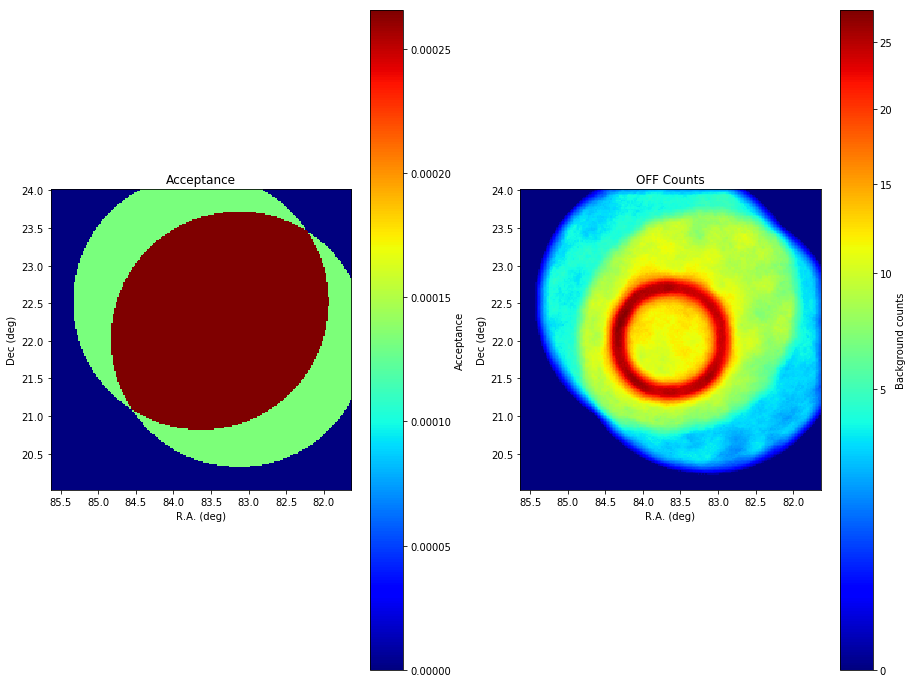

In [8]:
accmap = gammalib.GSkyMap(skymap['outmap'].filename()+'[ACCEPTANCE]') # Acceptance
bkgmap = gammalib.GSkyMap(skymap['outmap'].filename()+'[BACKGROUND]') # OFF counts

# Visualize the map
ax1 = plt.subplot(1,2,1)
plot_skymap(accmap, ztitle='Acceptance', title='Acceptance')
ax2 = plt.subplot(1,2,2)
plot_skymap(bkgmap, ztitle='Background counts', title='OFF Counts', norm=colors.PowerNorm(gamma=0.5))
plt.tight_layout()

As expected, there's a deficit ring around the Crab. Why? Because we didn't exclude the Crab! So let's apply the exclusion map that we defined above.

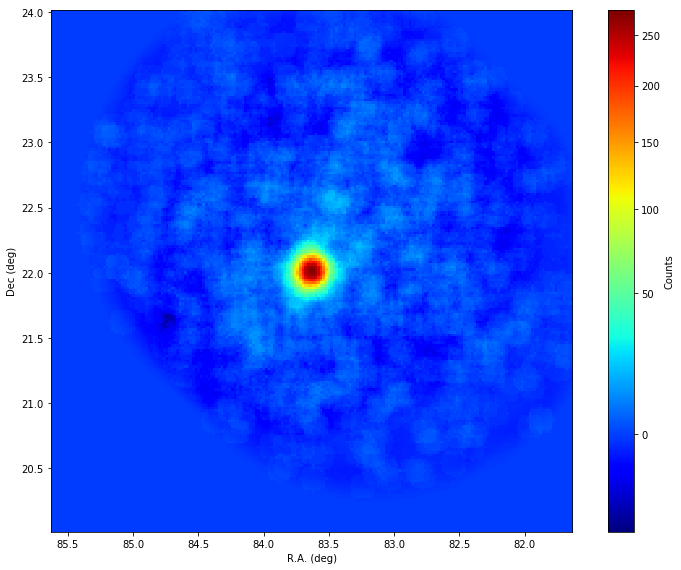

In [9]:
# Clear the old map and define exclusions
skymap.exclusion_map(gammalib.GSkyRegionMap(exclmap))
skymap.execute()

# Visualize the map
plot_skymap(skymap.skymap(), ztitle='Counts', norm=colors.PowerNorm(gamma=0.5))

That looks much better! 

**IMPORTANT NOTE:** You should keep in mind that this is not a TRUE RBM map. There is no accounting for the changing background sensitivity, so the difference in the area between the ring and source region is the only correction applied to the estimate of OFF counts in the ON region. It is possible to add a background IRF column to the data, which would then be used for weighting pixels in the OFF region. However, the observations we're using don't have that information, so it is ignored when generating the above maps.

We can visualize the generated acceptance map and background maps in the following way

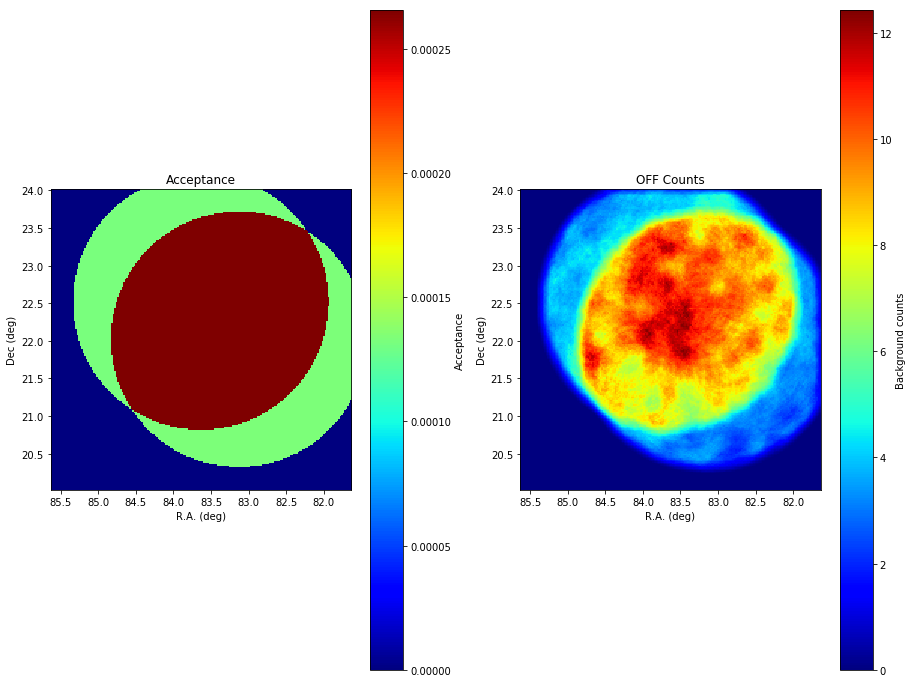

In [10]:
accmap = gammalib.GSkyMap(skymap['outmap'].filename()+'[ACCEPTANCE]')
bkgmap = gammalib.GSkyMap(skymap['outmap'].filename()+'[BACKGROUND]')

# Visualize the map
ax1 = plt.subplot(1,2,1)
plot_skymap(accmap, ztitle='Acceptance', title='Acceptance')
ax2 = plt.subplot(1,2,2)
plot_skymap(bkgmap, ztitle='Background counts', title='OFF Counts')
plt.tight_layout()

As expected the acceptance is flat over the entire field of view.

`ctskymap` also computes a significance map if background subtraction is requested. As of v1.6.0 there is no way to directly access this map from ctskymap, but it is saved in the output skymap file under the 'SIGNIFICANCE' header keyword. We can load this in the following way:

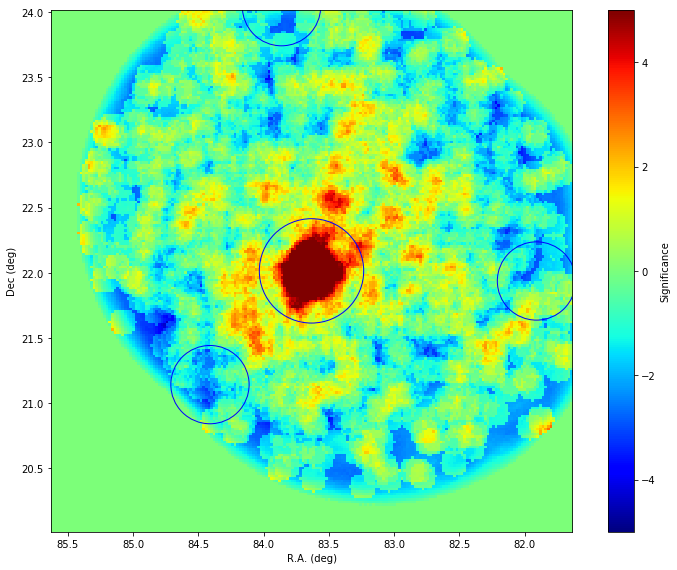

In [11]:
sigmap = gammalib.GSkyMap(skymap['outmap'].filename()+'[SIGNIFICANCE]')
plot_skymap(sigmap, ztitle='Significance')
plt.clim(-5,5)
ax = plt.gca()

# Add exclusion regions
from matplotlib.patches import Circle
for reg in regions:
    circle = Circle((reg.centre().ra_deg(), reg.centre().dec_deg()), reg.radius(), 
                    fill=False, color='blue')
    ax.add_patch(circle)

There is also a python script that is capable of generating the significance distributions. Let's take a look and apply this script to our significance map.

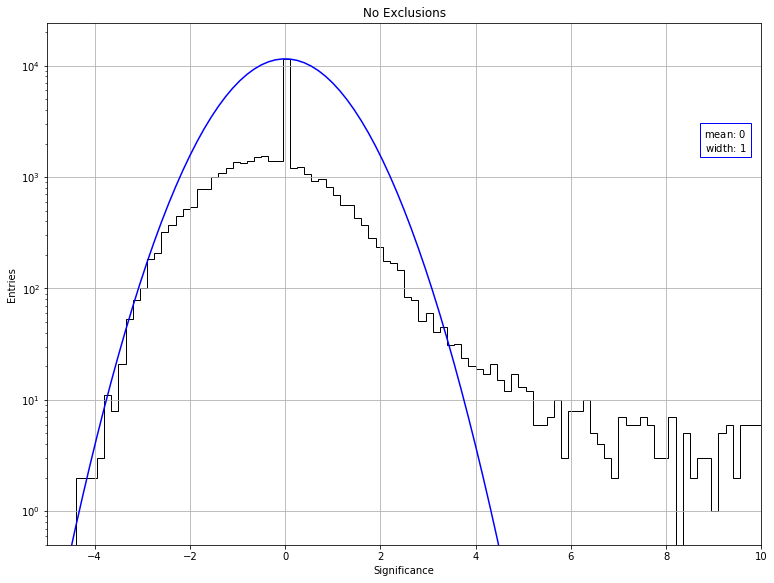

In [12]:
# Load the module
import os, sys
sys.path.append(os.environ['CTOOLS']+'/share/examples/python/')
from show_significance_distribution import plot_significance_distribution

# Plot the full distribution
plot_significance_distribution(skymap['outmap'].filename(), 100, -5, 10, 
                               '', '', 'No Exclusions', '')

Notice the very large peak at 0 because we are not excluding all of the bins where we have no data. There are two ways around this:
1. **Zoom in on the region we actually care about:** This is fairly easy, just rerun ctskymap with fewer bins in x,y.
2. **Pass 'inclusion' regions to the significance generator:** For this, we need to generate a list of regions based on the field of view of all our observations

In [13]:
# Create a regions container
obs_regions = gammalib.GSkyRegions()

# Loop over all obser
for obs in gammalib.GObservations(obsfile):
    roi = obs.roi()
    reg = gammalib.GSkyRegionCircle(roi.centre().dir(), roi.radius())
    obs_regions.append(reg)

obs_reg_file = 'resources/obs_reg.reg'
obs_regions.save(obs_reg_file)

Now we can pass this as the list of 'inclusion' regions

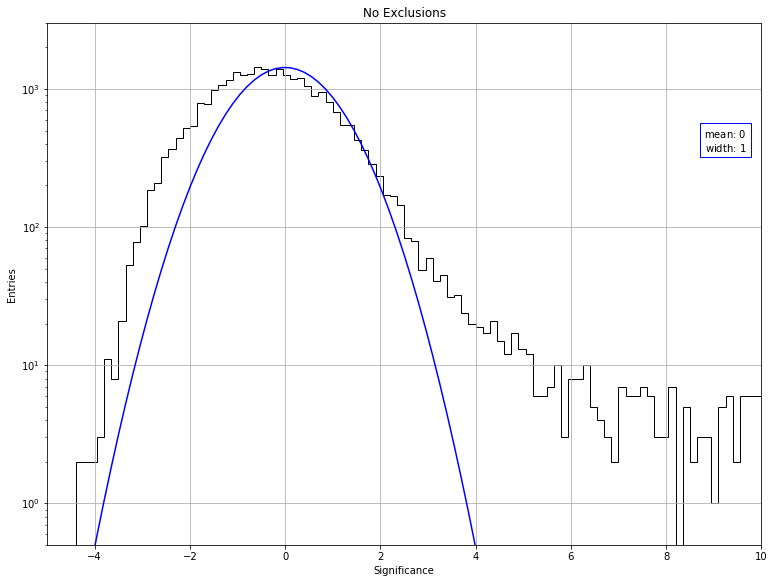

In [14]:
# Plot the full distribution
plot_significance_distribution(skymap['outmap'].filename(), 100, -5, 10, 
                               obs_reg_file, '', 'No Exclusions', '')

We can also pass the exclusion region files that we defined above to exclude specific regions around stars and the source.

Fit of normal distribution to excluded source significance data results in:  norm=1321.444778+=9.912881  xmean=-0.258915+-0.007434 sigma=1.185619+-0.005055


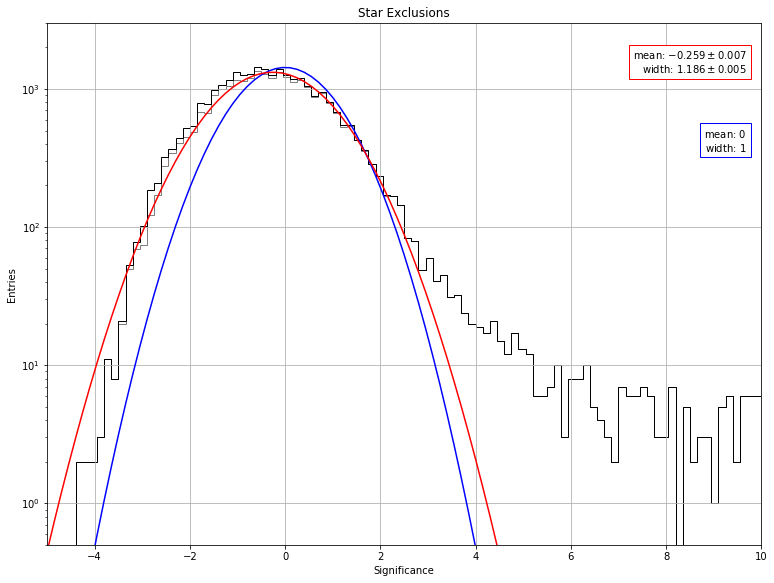

Fit of normal distribution to excluded source significance data results in:  norm=1322.856622+=10.018044  xmean=-0.317452+-0.007277 sigma=1.153111+-0.004921


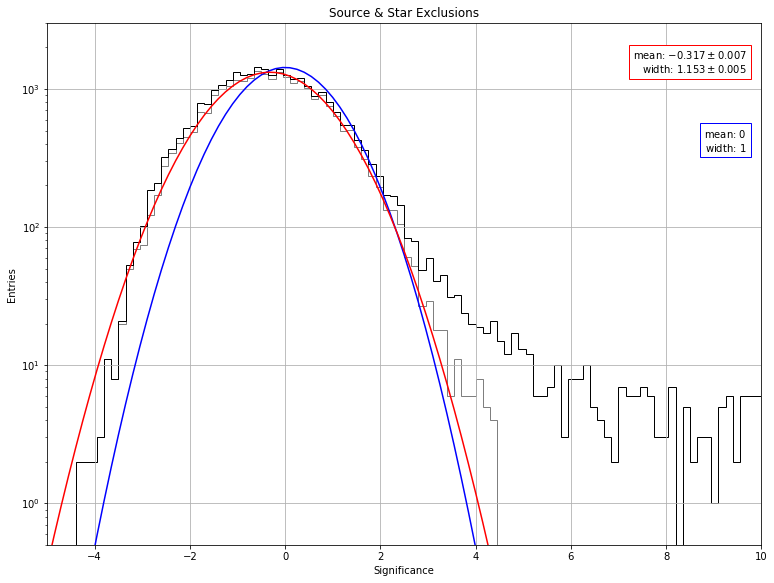

In [16]:
# Plot the full distribution without stars
plot_significance_distribution(skymap['outmap'].filename(), 100, -5, 10, 
                               obs_reg_file, excl_reg_stars, 'Star Exclusions', '')
plot_significance_distribution(skymap['outmap'].filename(), 100, -5, 10, 
                               obs_reg_file, excl_reg_all, 'Source & Star Exclusions', '')